In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
from keras import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models , callbacks
from keras import Sequential
from keras.layers import Dense , Conv2D , MaxPool2D , Flatten
from PIL import Image , ImageOps    ## PIL ----> python imaging library

# Load CIFAR-10 dataset which contains 32x32 RGB images of 10 different classes


In [71]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Checking the shape of training data to understand input dimensions


In [72]:
print('x_train_shape :' , x_train.shape)
print('y_train_shape :' , y_train.shape)
print('x_test_shape :' , x_test.shape)
print('y_test_shape :' , y_test.shape)

x_train_shape : (50000, 32, 32, 3)
y_train_shape : (50000, 1)
x_test_shape : (10000, 32, 32, 3)
y_test_shape : (10000, 1)


# Normalize pixel values to range 0-1 for better and faster model training


# Converting image data to float32 because neural networks require floating-point precision for gradient-based learning


In [73]:
train_image = x_train.astype('float32') / 255
test_image = x_test.astype('float32') / 255

plotting of image from training data

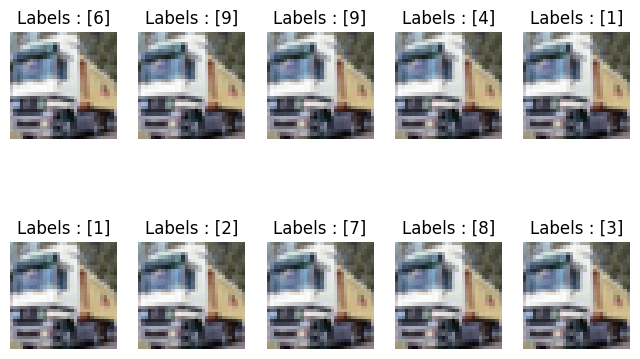

In [74]:
plt.figure(figsize=(8,5))

for i in range(10): ##Loop 0 se 9 tak chalega
  plt.subplot(2,5 , i+1) ## Figure ko 2 rows × 5 columns me divide kar do i+1 isliye kuki subplot index must be >=1
  img = train_image[1] ##Matlab : Training dataset me se i-th image uthao
  plt.imshow(img , cmap = 'gray') ##Matlab : Image ko plot karo cmap='gray' → grayscale me dikhana
  plt.title(f'Labels : {y_train[i]}') ## Matlab : Image ke upar label likh do train_labels[i] = us image ka class
  plt.axis('off') ## Matlab : X-axis aur Y-axis hata do Sirf image clean dikhe

In [75]:
y_train.shape

(50000, 1)

# Removing extra dimension from labels to match sparse_categorical_crossentropy requirements


In [76]:
y_train = y_train.reshape(-1,) ##“Bracket hata do. Bas number de do.”
y_test = y_test.reshape(-1,) ##Labels ko 1D array me convert kar rahe hain

In [77]:
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [78]:
y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [92]:
from tensorflow.keras import models , layers

def create_model(hp = None):
  model = models.Sequential([

         # -------- Block 1 --------
    layers.Conv2D(filters = hp.Choice('filter_1' , [32,64]),
                  kernel_size = (3,3),
                  activation= 'relu',
                  input_shape = (32,32,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

         # -------- Block 2 --------
    layers.Conv2D(64, (3,3) , activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

        # -------- Block 3 --------
    layers.Conv2D(64, (3,3) , activation= 'relu'),
    layers.BatchNormalization(),

         # -------- Classifier --------
    layers.Flatten(),
    layers.Dense(128 , activation= 'relu'),
    layers.Dropout(0.5),
    layers.Dense(10 , activation= 'softmax')  # Softmax is used in the output layer to convert logits into
# class probabilities for multi-class classification (Sab outputs ko 0–1 ke beech laata hai)

  ])
  return model

# Compiling the model with Adam optimizer and sparse categorical loss


In [109]:
# model = create_model()
# model.compile(
#     optimizer = 'adam',
#     loss = 'sparse_categorical_crossentropy',
#     metrics = ['accuracy']
# )

# Applying data augmentation to improve model generalization


In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = 0.1
)

In [81]:
datagen.fit(x_train)

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=5 , restore_best_weights=True)

# Training the CNN model on CIFAR-10 dataset


In [110]:
# history = model.fit(datagen.flow(x_train , y_train , batch_size = 64),
#                     epochs = 30,
#                     validation_data = (x_test , y_test),
#                     callbacks = [early_stopping])

# Evaluating model performance on unseen test data


In [111]:
# model.evaluate(x_test, y_test)

# Visualizing training and validation accuracy to detect overfitting


In [112]:
# plt.figure(figsize=(12,4))
# plt.plot(history.history['accuracy'] , label = 'training accuracy')
# plt.plot(history.history['val_accuracy'] , label = 'validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# Visualizing training and validation loss to detect overfitting


In [113]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'] , label = 'training loss')
plt.plot(history.history['val_loss'] , label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

2️⃣ Problem clear hai

Learning rate maybe high

Dropout thoda aggressive

Filters / dense units optimal nahi

# Searching for optimal hyperparameters using data augmentation and validation data


In [94]:
#best option is to check hyperparamter tuning
!pip install keras-tuner --upgrade

In [95]:
from keras_tuner.src.engine import objective
import keras_tuner as kt

tuner = kt.RandomSearch(
    create_model,
    objective = 'val_accuracy',
    max_trials = 5,
    directory = 'kt_dir',
    project_name = 'cifar10_cnn'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 8,
    restore_best_weights = True
)

In [101]:
tuner.search(
    datagen.flow(x_train , y_train , batch_size= 64),
    epochs = 30,
    validation_data = (x_test , y_test),
    # callbacks = [early_stopping]
)

Trial 2 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 02s


In [103]:
best_model = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_model)
for param in best_model.values:
  print(f"{param} : {best_model.get(param)}")

filter_1 : 64


In [114]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hp)


In [116]:
best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [118]:
history = best_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6245 - loss: 1.0710 - val_accuracy: 0.5063 - val_loss: 1.6609
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6341 - loss: 1.0500 - val_accuracy: 0.6645 - val_loss: 0.9568
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6463 - loss: 1.0175 - val_accuracy: 0.6640 - val_loss: 0.9638
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6555 - loss: 0.9949 - val_accuracy: 0.6123 - val_loss: 1.1344
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6576 - loss: 0.9800 - val_accuracy: 0.6886 - val_loss: 0.9180
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6578 - loss: 0.9861 - val_accuracy: 0.7374 - val_loss: 0.7612
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6683 - loss: 0.9514 - val_accuracy: 0.7006 - val_loss: 0.8708
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6750 - loss: 0.9402 - 

In [119]:
best_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7404 - loss: 0.7536


[0.7483121156692505, 0.7440000176429749]

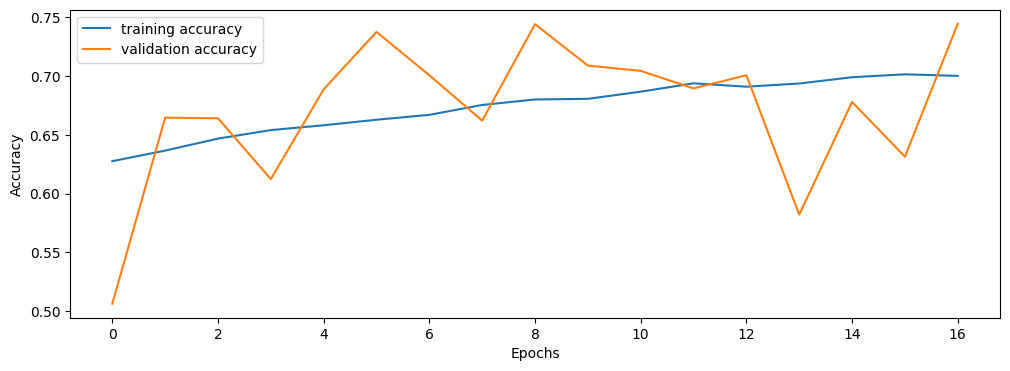

In [120]:
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'] , label = 'training accuracy')
plt.plot(history.history['val_accuracy'] , label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

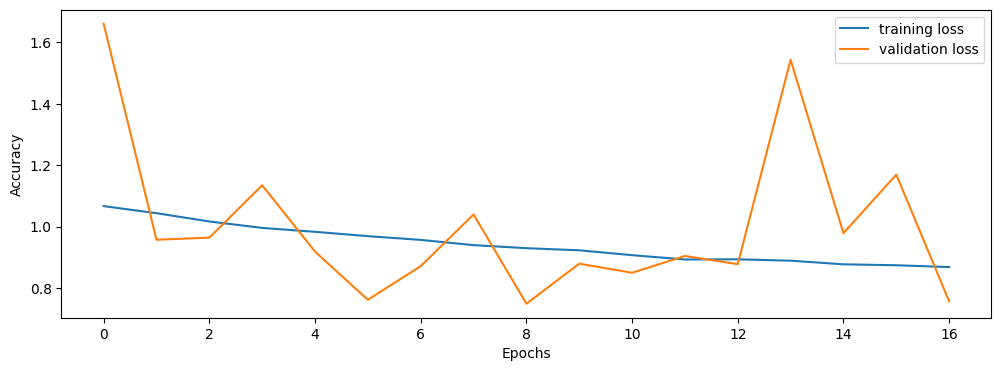

In [121]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'] , label = 'training loss')
plt.plot(history.history['val_loss'] , label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [122]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(best_model.predict(x_test), axis=1)

print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1000
           1       0.82      0.92      0.87      1000
           2       0.74      0.55      0.63      1000
           3       0.66      0.43      0.52      1000
           4       0.77      0.63      0.69      1000
           5       0.67      0.67      0.67      1000
           6       0.63      0.90      0.74      1000
           7       0.77      0.82      0.79      1000
           8       0.80      0.89      0.84      1000
           9       0.83      0.82      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [131]:
model.save('Cifar10_CNN_model.h5')

In [132]:
from tensorflow.keras.models import load_model

model = load_model('Cifar10_CNN_model.h5')

In [159]:
import numpy as np

prediction = model.predict(x_test)
y_pred = np.argmax(prediction , axis = 1)  ### yaha basically model ne jo predictions kari hai image ki vo hai

prediction[0] #model ne iss image ko class 3 predict kara that is cat

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


np.int64(3)

In [160]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test , y_pred)*100 #model ne cat bola or y_test me jo tha usse accurace nikli 71.26

71.26

array([[[118, 105,  99],
        [119, 106, 100],
        [124, 111, 104],
        ...,
        [187, 113,  62],
        [142,  64,  19],
        [153,  75,  30]],

       [[114, 101,  95],
        [113, 101,  95],
        [115, 101,  94],
        ...,
        [147,  63,  27],
        [140,  65,  17],
        [162,  91,  38]],

       [[111,  98,  92],
        [111,  98,  92],
        [111,  99,  91],
        ...,
        [126,  51,  14],
        [154,  92,  35],
        [180, 119,  58]],

       ...,

       [[ 92,  81,  82],
        [ 92,  82,  83],
        [ 92,  82,  80],
        ...,
        [ 76,  67,  60],
        [ 77,  68,  61],
        [ 75,  66,  60]],

       [[ 84,  77,  77],
        [ 86,  79,  79],
        [ 87,  80,  79],
        ...,
        [ 81,  71,  65],
        [ 80,  71,  64],
        [ 78,  68,  63]],

       [[ 88,  84,  69],
        [ 84,  81,  66],
        [ 82,  78,  65],
        ...,
        [ 87,  78,  69],
        [ 86,  78,  69],
        [ 84,  75,  67]]], dtype=uint8)
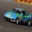

In [165]:
img = x_test[4999]
img.shape
img

In [166]:
img = img.reshape(1,32,32,3)

In [171]:
prediction = model.predict(img)
class_id = np.argmax(prediction)
# print(prediction)
print(f'class id is: {class_id}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
class id is: 1


In [156]:
class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

print("Predicted:", class_names[class_id])


Predicted: automobile
